# Churn Rate Competition

В соревновании необохдимо смоделировать отток клиентов телеком компании на основании предоставленных данных

[ссылка на соревнование](https://www.kaggle.com/competitions/advanced-dls-spring-2021/overview
)

In [ ]:
!pip install phik

In [ ]:
!pip install optuna

In [ ]:
!pip install prince

In [386]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier

import phik
import prince

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [198]:
train = pd.read_csv('drive/MyDrive/data/c_train.csv')
test = pd.read_csv('drive/MyDrive/data/c_test.csv')

## EDA

In [ ]:
train.head(3)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1


Очевидно, присутствует дизбаланс классов, один превосходит другой более,чем в 2 раза

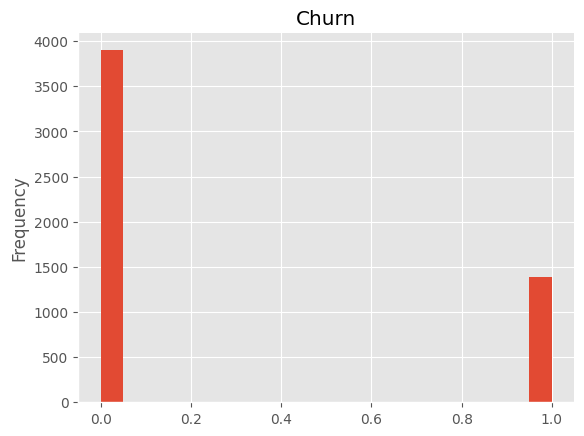

In [ ]:
from matplotlib import pyplot as plt
train['Churn'].plot(kind='hist', bins=20, title='Churn')
plt.gca().spines[['top', 'right',]].set_visible(False)

Видно, что больше информации о пользователях, которые либо только недавно начали пользоваться продуктом, либо наоборот очень долго пользуются

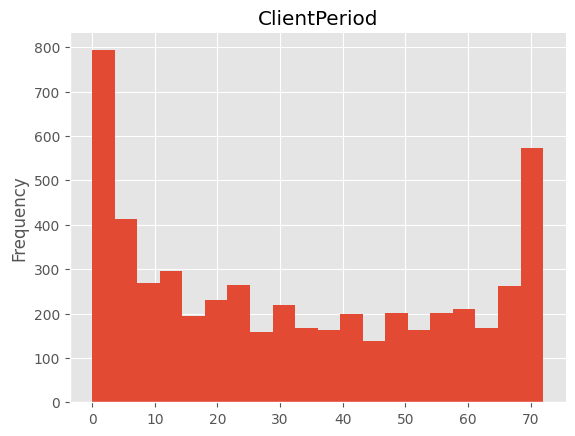

In [ ]:
from matplotlib import pyplot as plt
train['ClientPeriod'].plot(kind='hist', bins=20, title='ClientPeriod')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [199]:
train['TotalSpent'] = train['TotalSpent'].replace(' ', np.nan)
test['TotalSpent'] = test['TotalSpent'].replace(' ', np.nan)

In [200]:
train.isna().sum().sum() + test.isna().sum().sum()

11

In [201]:
train['TotalSpent'] = train['TotalSpent'].astype(float)
test['TotalSpent'] = test['TotalSpent'].astype(float)

In [202]:
train['TotalSpent'] = train['TotalSpent'].fillna(train['TotalSpent'].median())
test['TotalSpent'] = test['TotalSpent'].fillna(train['TotalSpent'].median())

In [203]:
num_columns = train.loc[:, train.dtypes != object].columns.drop(['Churn','IsSeniorCitizen'])
cat_columns = train.loc[:, train.dtypes == object].columns
cat_columns = cat_columns.append(pd.Index(['Churn']))
cat_columns = cat_columns.append(pd.Index(['IsSeniorCitizen']))

In [204]:
test['TotalSpent'] = test['TotalSpent'].replace(' ', np.nan)

Посмотрим матрицу корелляций

<Axes: >

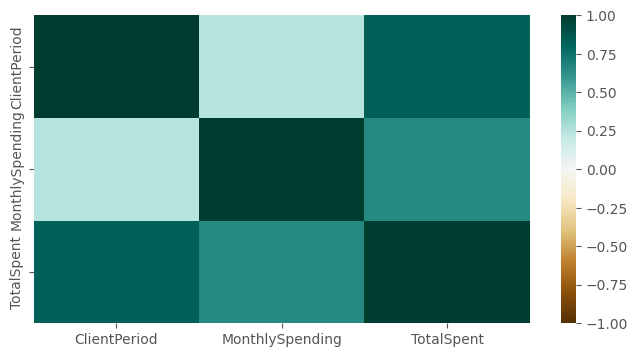

In [ ]:
fig = plt.figure(figsize=(8,4))
sns.heatmap(train[num_columns].corr(),
            xticklabels=num_columns,
            yticklabels=num_columns,
            cmap='BrBG',
            vmin = -1,
            vmax=1)

ClientPeriod и TotalSpent сильно кореллируют
MonthlySpending и TotalSpent тоже кореллируют хорошо, но поменьше
А вот ClientPeriod и MonthlySpending плохо кореллируют

In [ ]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop
+
def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(train[num_columns], 10))

Top Absolute Correlations
ClientPeriod     TotalSpent         0.825871
MonthlySpending  TotalSpent         0.651838
ClientPeriod     MonthlySpending    0.249414
dtype: float64


## Посмотрим на коэффициенты корелляции phi_k вычисленные при помощи статистик хи-квадрат
- категория Sex никак не влияет на таргет, а так мже никак не связана ни с какой из переменных? ее можно удалить
- группа категориальных переменных, состоящая из HasMultiplePhoneNumbers,	HasInternetService,	HasOnlineSecurityService,	HasOnlineBackup,	HasDeviceProtection,	HasTechSupportAccess,	HasOnlineTV,	HasMovieSubscription,	HasContractPhone между собой очень скореллированы, а так же все они скореллированы с MonthlySpending, имеет смысл применить PCA
- HasPhoneService и	HasMultiplePhoneNumbers полностью скореллированы, а так же практически не влияют на таргет, можно удалить

interval columns not set, guessing: ['ClientPeriod', 'MonthlySpending', 'TotalSpent', 'IsSeniorCitizen', 'Churn']


<Axes: >

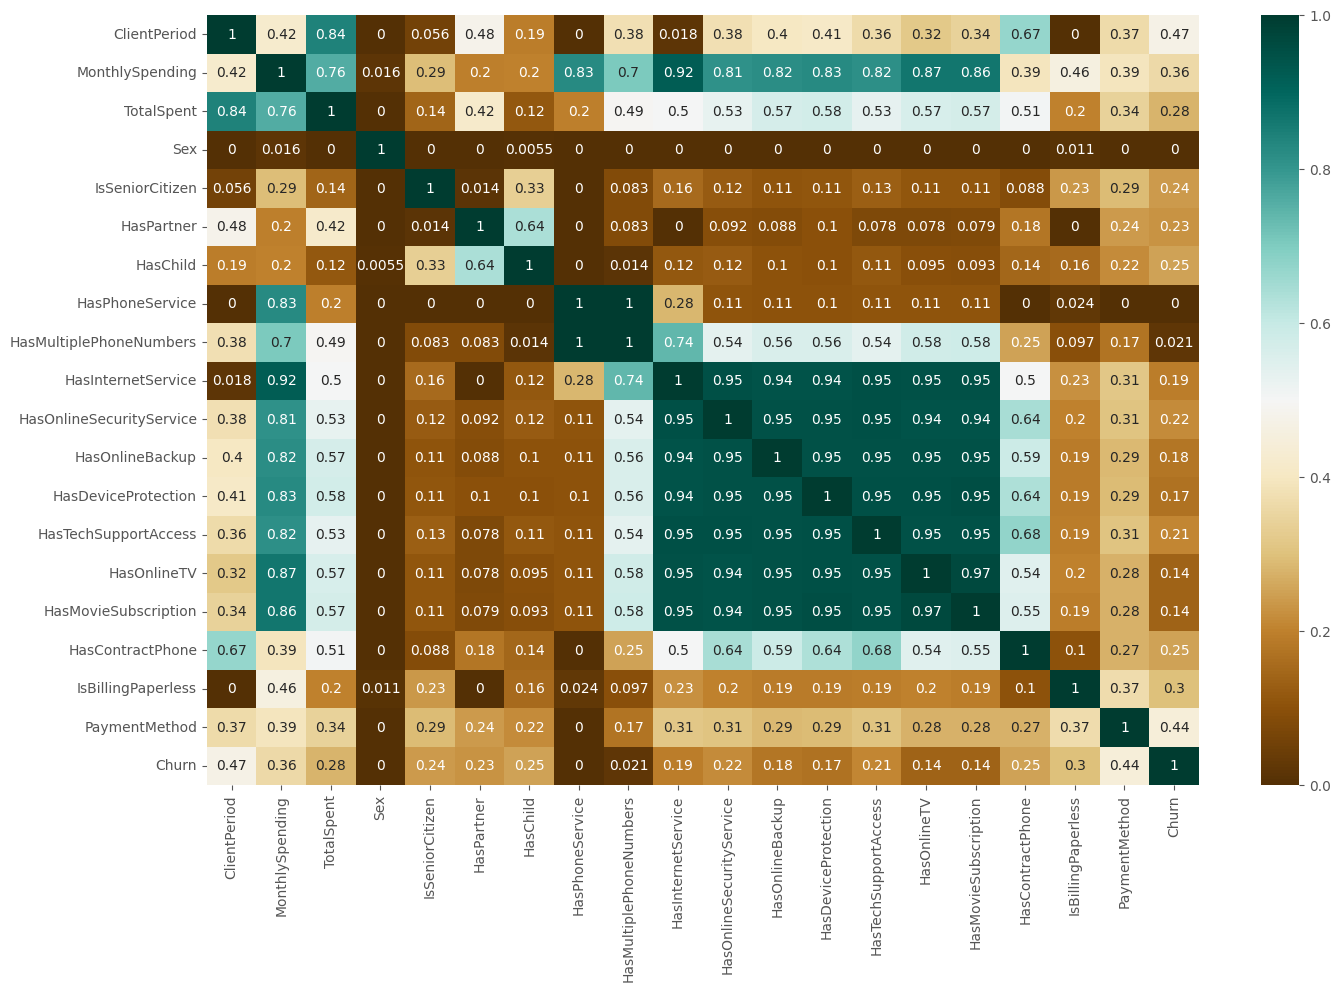

In [ ]:
ph = train.phik_matrix()

fig = plt.figure(figsize=(16,10))
sns.heatmap(ph, cmap='BrBG', annot=True)

## Построим Barcharts
- видно, что для разных классов распределения отличаются, так тчо отбрасывать признаки на основании этих характеристик не будем

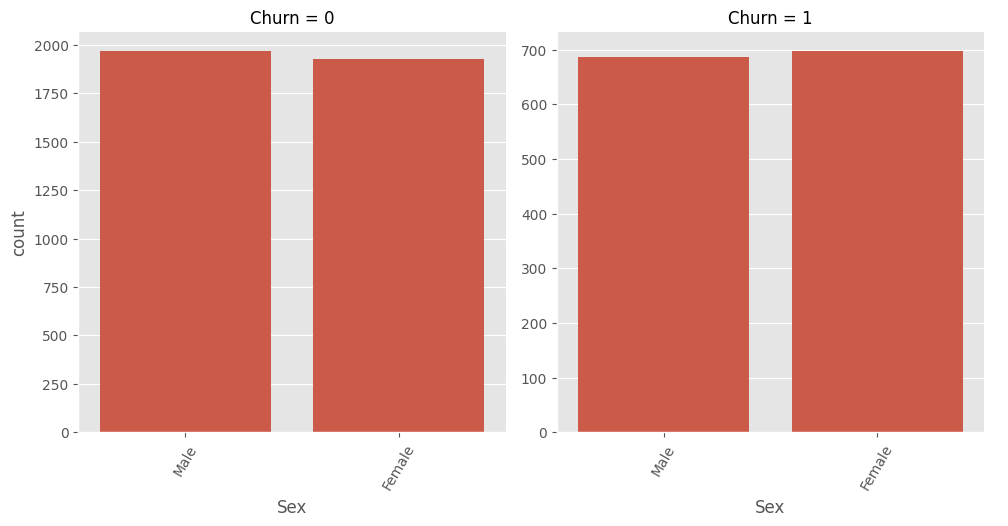

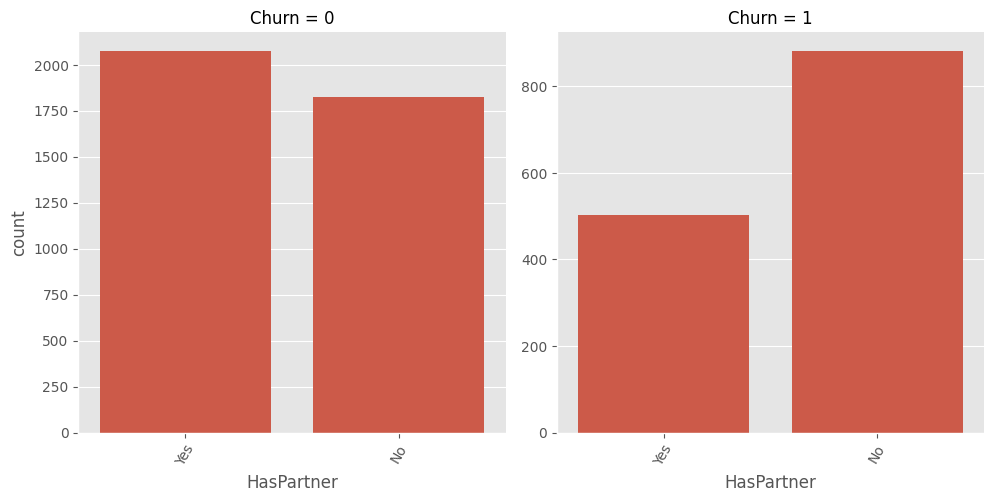

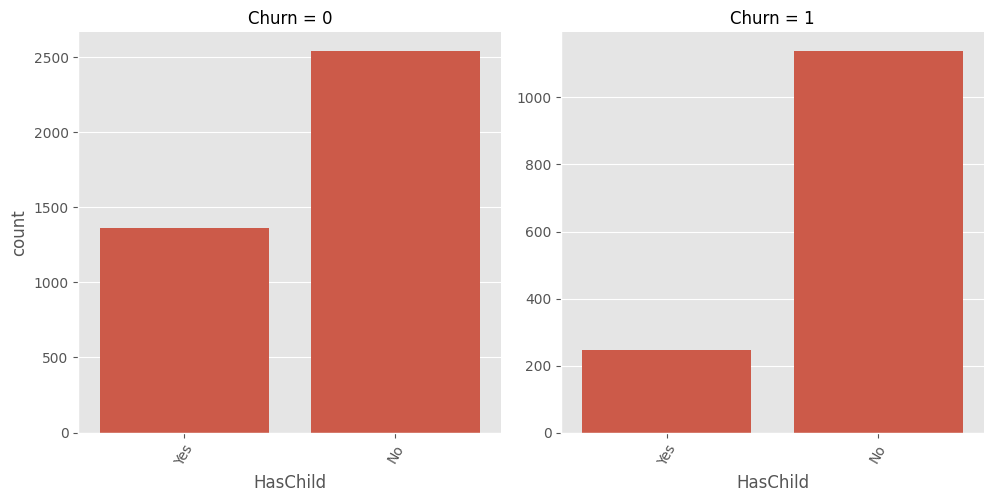

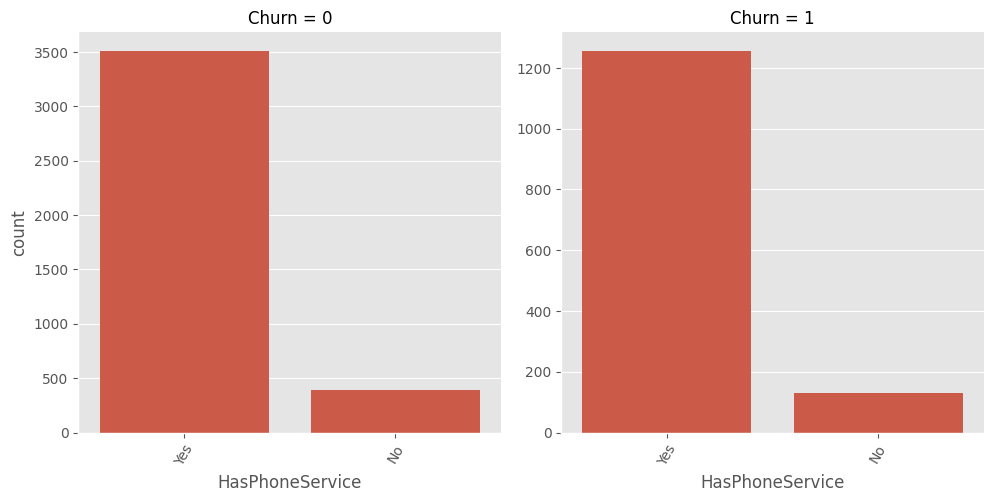

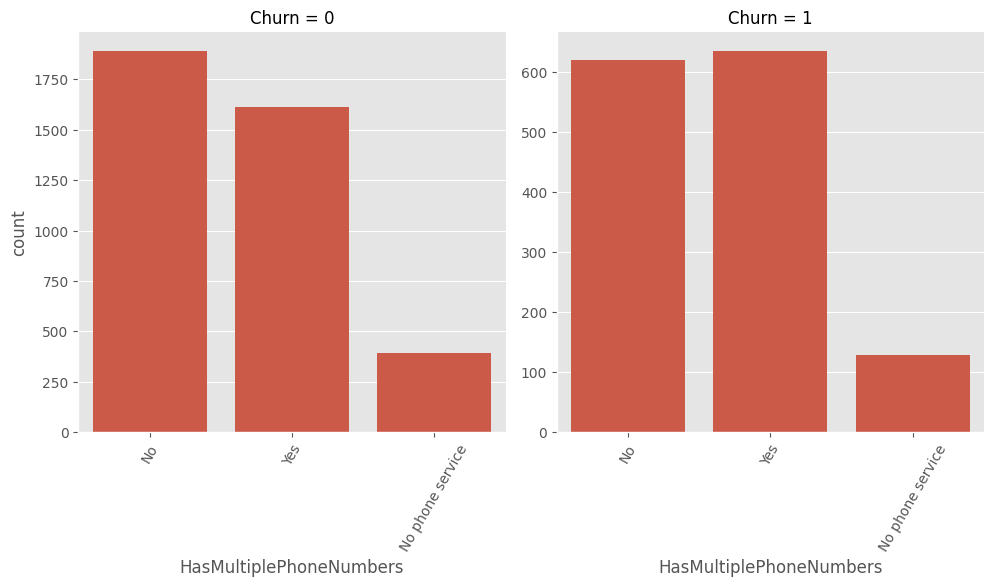

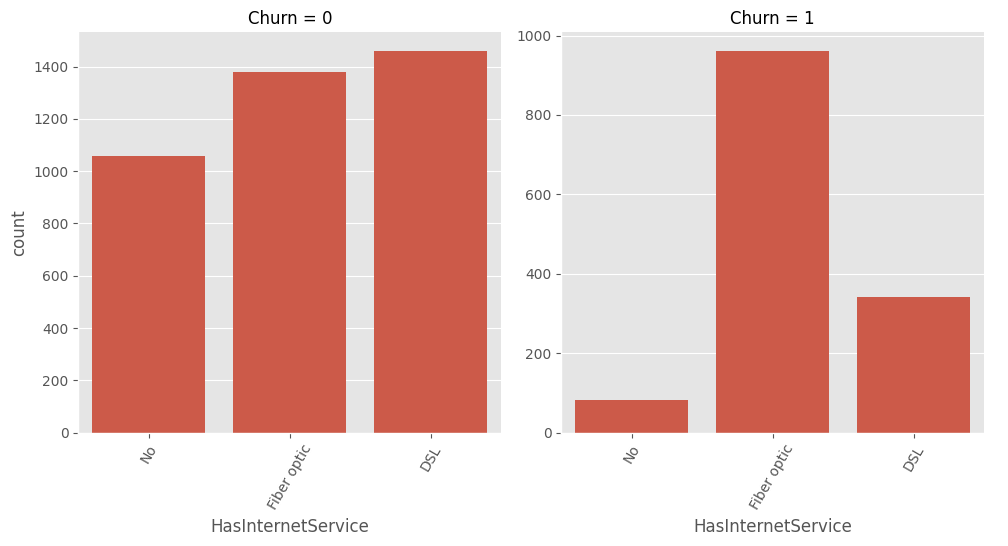

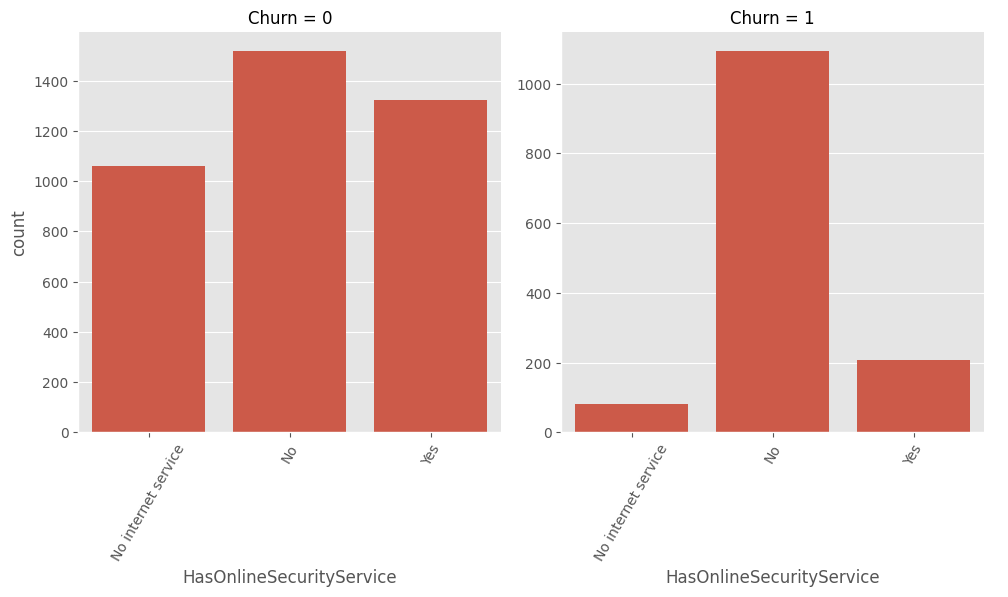

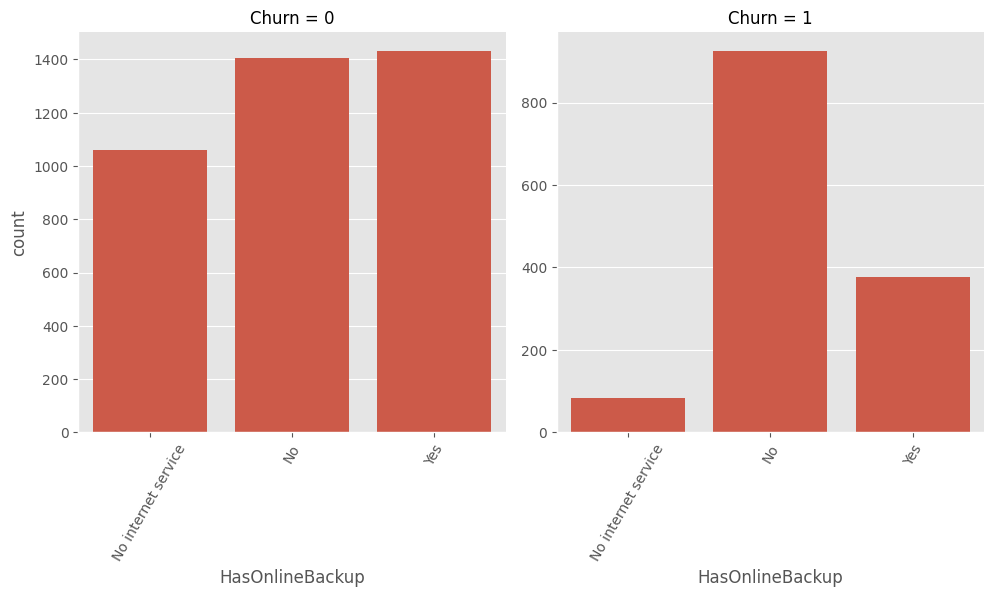

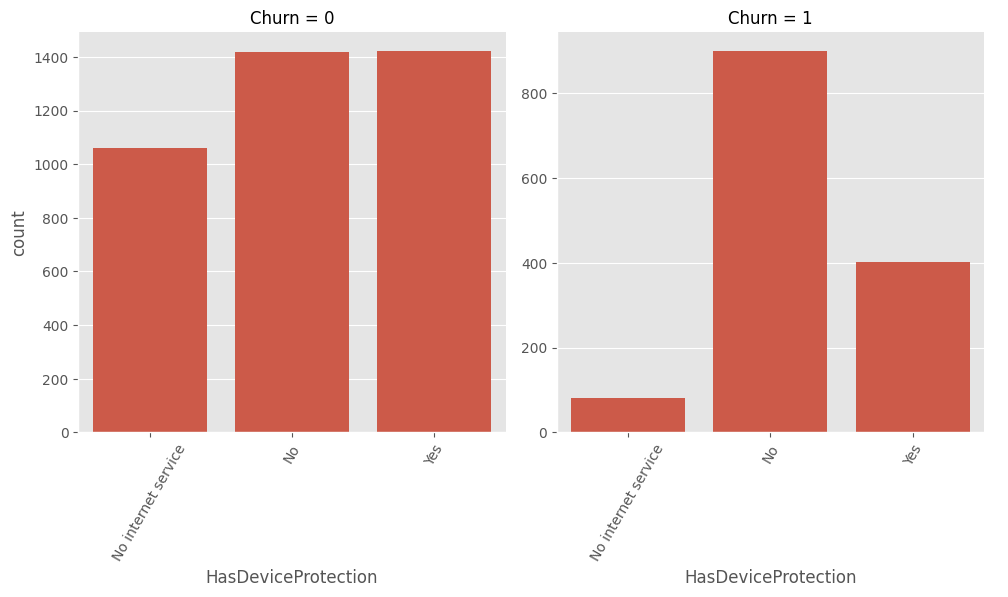

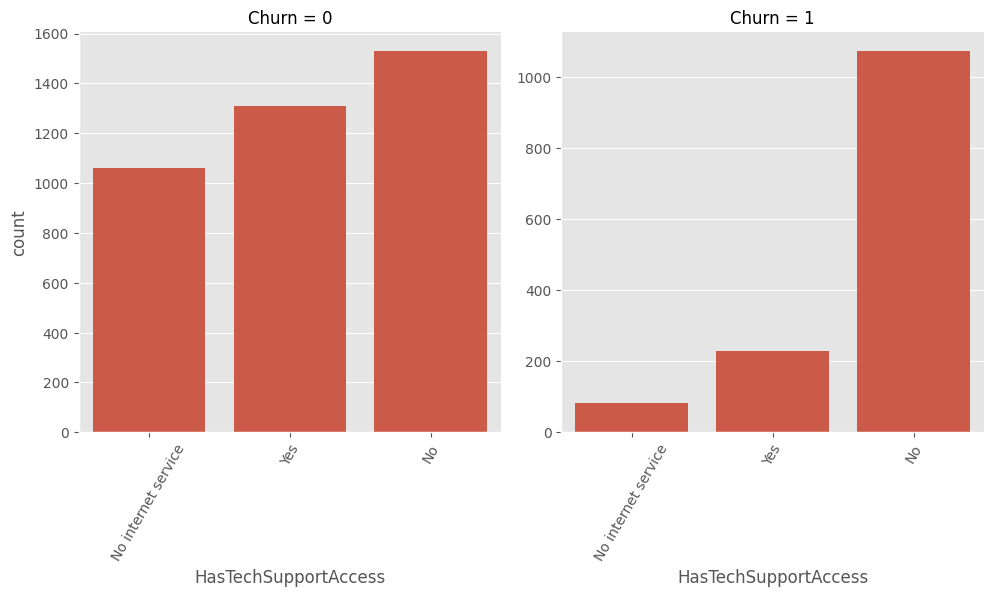

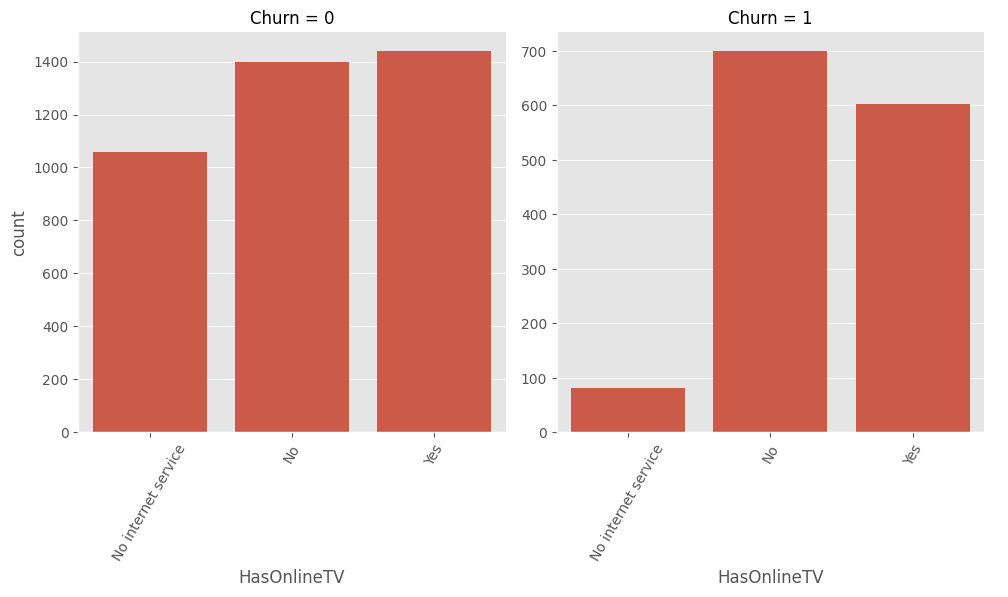

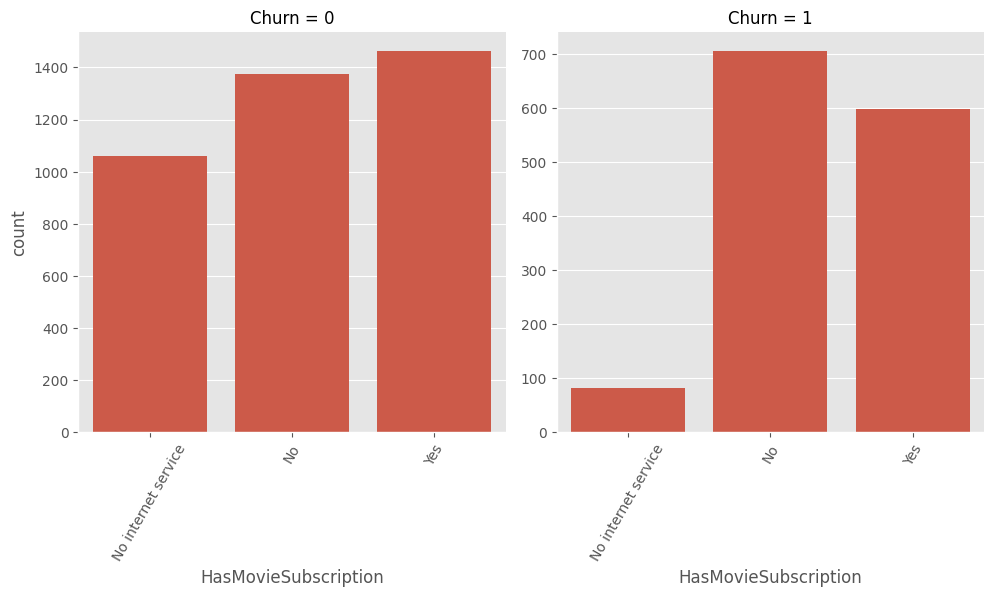

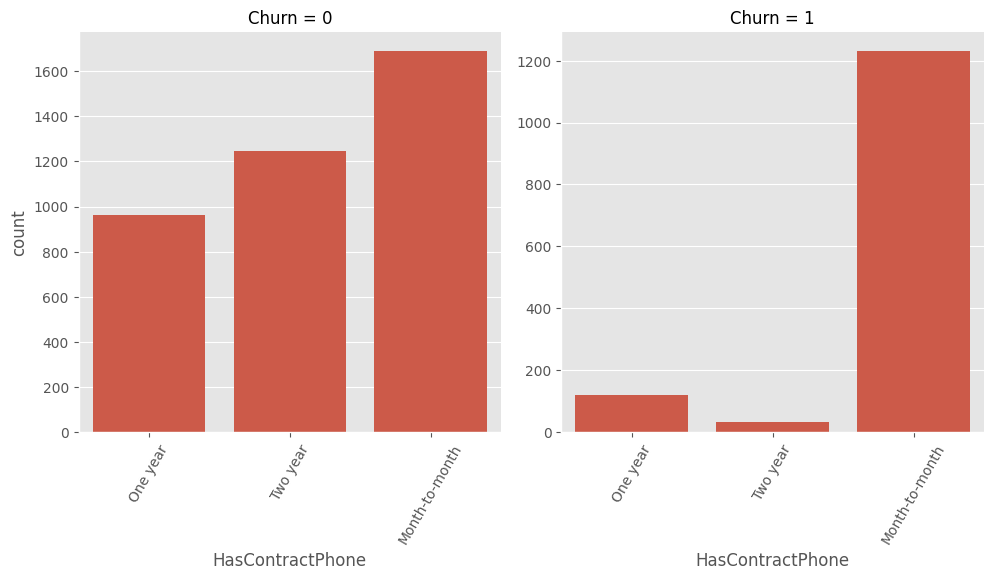

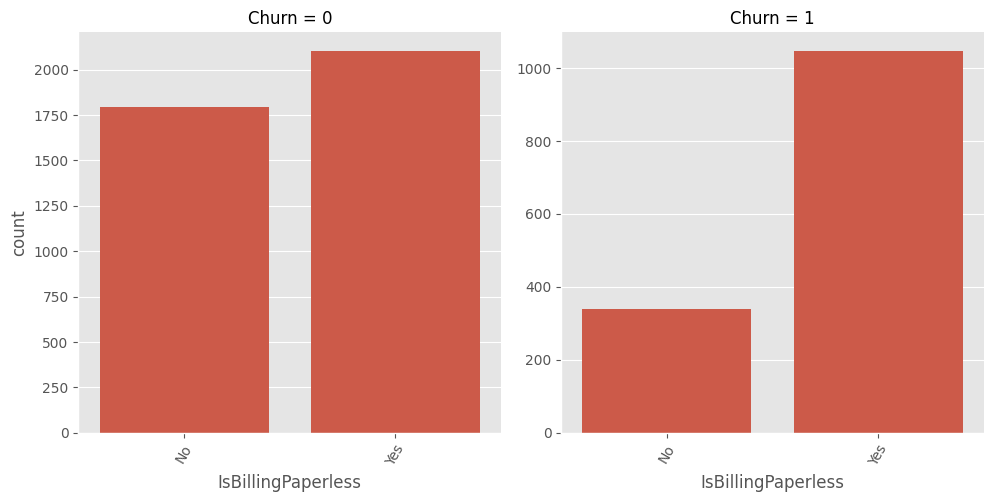

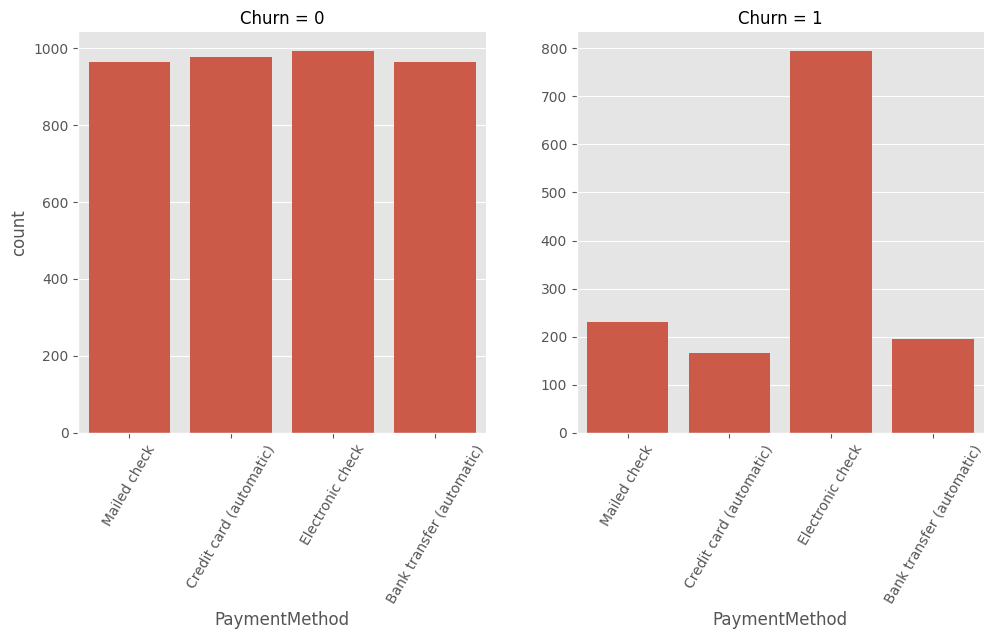

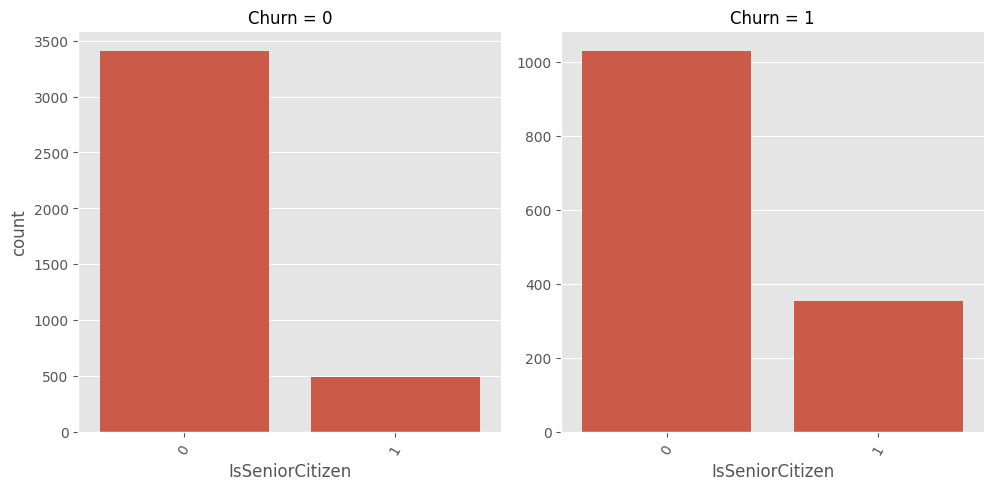

In [ ]:
for col in cat_columns:
    if col != 'Churn':
        g = sns.catplot(x=col, kind='count',col='Churn', data=train, sharey=False)
        g.set_xticklabels(rotation=60)

## Boxplots
- ящики с усами показывают, что выбрасывать числовые переменные не следует
- стоит проанализировать выбросы

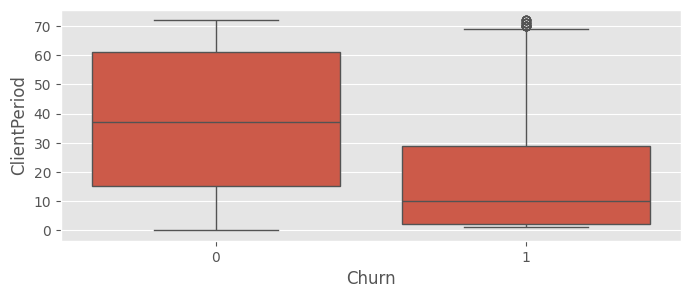

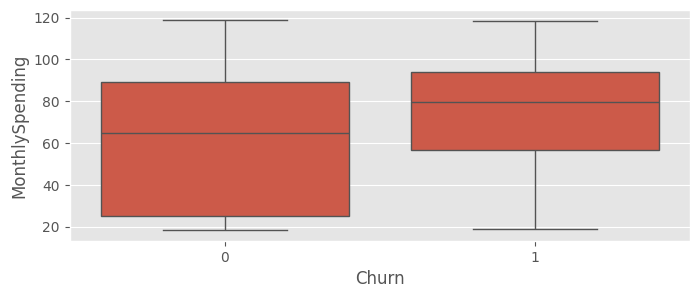

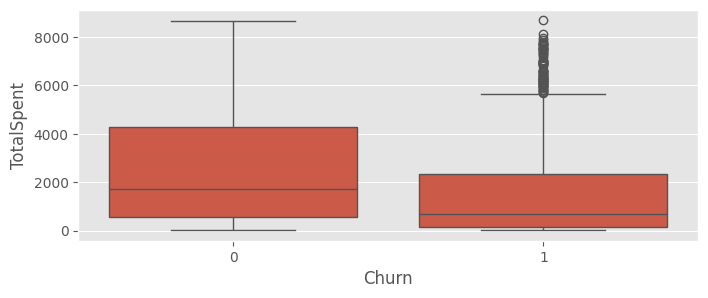

In [14]:
for col in num_columns:
    fig = plt.figure(figsize=(8,3))
    sns.boxplot(y=col, x=train['Churn'].astype('category'), data=train)
    plt.show()

## Анализ выбросов
- Явных выбросов не обнаружено

In [13]:
train.describe(exclude='object').drop(['IsSeniorCitizen','Churn'], axis=1)

,ClientPeriod,MonthlySpending,TotalSpent
count,5282.000000,5282.000000,5282.000000
mean,32.397009,64.924754,2289.889086
std,24.550326,30.176464,2267.371263
min,0.000000,18.250000,18.800000
25%,9.000000,35.462500,401.587500
50%,29.000000,70.400000,1410.250000
75%,55.000000,90.050000,3795.212500
max,72.000000,118.750000,8684.800000


In [48]:
top_quantile = train['TotalSpent'].quantile(0.99)
top_quantile

8017.787499999998

## Reature Engineering

In [205]:
# объединим датасет
full=pd.concat([train,test], ignore_index=True)

In [206]:
full.drop(['Sex', 'HasPhoneService', 'HasMultiplePhoneNumbers'], axis=1, inplace=True)

In [207]:
full = pd.get_dummies(full, columns=cat_columns.drop(['Sex', 'HasPhoneService', 'HasMultiplePhoneNumbers', 'Churn']))

In [208]:
full = full.drop('Churn', axis=1)

In [52]:
full

,ClientPeriod,MonthlySpending,TotalSpent,Churn,HasPartner_No,HasPartner_Yes,HasChild_No,HasChild_Yes,HasInternetService_DSL,HasInternetService_Fiber optic,...,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,IsSeniorCitizen_0,IsSeniorCitizen_1
0,55,19.50,1026.35,0.0,False,True,False,True,False,False,...,True,False,True,False,False,False,False,True,True,False
1,72,25.85,1872.20,0.0,False,True,True,False,False,False,...,False,True,True,False,False,True,False,False,True,False
2,1,75.90,75.90,1.0,True,False,True,False,False,True,...,False,False,False,True,False,False,True,False,True,False
3,32,79.30,2570.00,0.0,False,True,True,False,False,True,...,False,False,True,False,False,False,False,True,False,True
4,60,115.25,6758.45,0.0,False,True,False,True,False,True,...,False,True,True,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,71,105.15,7555.00,NaN,False,True,True,False,False,True,...,False,True,False,True,True,False,False,False,True,False
7039,13,20.85,272.35,NaN,False,True,False,True,False,False,...,False,True,True,False,False,False,False,True,True,False
7040,2,91.45,171.45,NaN,False,True,True,False,False,True,...,False,False,False,True,False,False,True,False,True,False
7041,19,89.10,1620.80,NaN,False,True,True,False,False,True,...,False,False,False,True,False,False,True,False,True,False


In [209]:
# удалим лишние столбцы, чтобы не попасть в dummy variable trap
full = full.drop(['HasPartner_No','HasChild_No','HasInternetService_DSL',
                  'HasOnlineSecurityService_No','HasOnlineBackup_No','HasDeviceProtection_No',
                  'HasTechSupportAccess_No','HasOnlineTV_No','HasMovieSubscription_No',
                  'HasContractPhone_Month-to-month', 'IsBillingPaperless_No',
                  'PaymentMethod_Bank transfer (automatic)','IsSeniorCitizen_0'], axis=1)

In [403]:
n_train=train.shape[0]
X = full[:n_train]
test_X = full[n_train:]
y= train.Churn

In [404]:
encoded_columns = ['HasInternetService_Fiber optic',
       'HasInternetService_No', 'HasOnlineSecurityService_No internet service',
       'HasOnlineSecurityService_Yes', 'HasOnlineBackup_No internet service',
       'HasOnlineBackup_Yes', 'HasDeviceProtection_No internet service',
       'HasDeviceProtection_Yes', 'HasTechSupportAccess_No internet service',
       'HasTechSupportAccess_Yes', 'HasOnlineTV_No internet service',
       'HasOnlineTV_Yes', 'HasMovieSubscription_No internet service',
       'HasMovieSubscription_Yes', 'HasContractPhone_One year',
       'HasContractPhone_Two year']

In [345]:
# применим PCA для сжатия информации

num_components = 3
pca_model = PCA(n_components=num_components)
pca_model.fit(X[encoded_columns])

transformed_data_train = pca_model.transform(X[encoded_columns])
transformed_data_test = pca_model.transform(test_X[encoded_columns])

cols = [f'place_pca_{i}' for i in range(1, 4)]
X[cols] = transformed_data_train
test_X[cols] = transformed_data_test
test_X= test_X.drop(columns = encoded_columns)
X = X.drop(columns = encoded_columns)

MCA показал себя лучше на категориальных переменных

In [405]:
mca_model = prince.MCA(
    n_components=4,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)

mca_model.fit(X[encoded_columns])

transformed_data_train = mca_model.transform(X[encoded_columns])
transformed_data_test = mca_model.transform(test_X[encoded_columns])

cols = [f'place_mca_{i}' for i in range(1, 5)]
X[cols] = transformed_data_train
test_X[cols] = transformed_data_test
test_X= test_X.drop(columns = encoded_columns)
X = X.drop(columns = encoded_columns)

In [213]:
X.shape

(5282, 13)

In [406]:
scaler = StandardScaler()
columns_to_scale = ['TotalSpent', 'ClientPeriod',	'MonthlySpending']
X[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])
test_X[columns_to_scale] = scaler.transform(test_X[columns_to_scale])

## Models

In [347]:
def roc_auc_cv(model, X, y):
    roc_auc = cross_val_score(model, X, y, scoring="roc_auc", cv=5)
    return roc_auc

In [390]:
models = [LogisticRegression(),RidgeClassifier(),RandomForestClassifier(),GradientBoostingClassifier(),SVC(),LinearSVC(),
          SGDClassifier(max_iter=1000,tol=1e-3),ExtraTreesClassifier(),XGBClassifier(), KNeighborsClassifier(n_neighbors=44, metric='manhattan')]

In [391]:
names = ["LR", "Ridge","RF", "GBR", "SVC", "LinSVC","SGD","Extra","Xgb", 'KNN']
for name, model in zip(names, models):
    score = roc_auc_cv(model, X, y)
    print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))

LR: 0.840595, 0.0117
Ridge: 0.834152, 0.0133
RF: 0.809676, 0.0090
GBR: 0.837668, 0.0088
SVC: 0.785522, 0.0119
LinSVC: 0.838930, 0.0122
SGD: 0.824408, 0.0138
Extra: 0.782725, 0.0073
Xgb: 0.810863, 0.0102
KNN: 0.829898, 0.0087


### Подберем гиперпараметры

In [306]:
class grid():
    def __init__(self,model):
        self.model = model

    def grid_get(self,X,y,param_grid):
        grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring="roc_auc")
        grid_search.fit(X,y)
        print(grid_search.best_params_, grid_search.best_score_)
        grid_search.cv_results_['mean_test_score'] = grid_search.cv_results_['mean_test_score']
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

In [ ]:
grid(RidgeClassifier()).grid_get(X,y,{'alpha':[35,40,45,50,55,60,65,70,80,90]})

In [ ]:
grid(RandomForestClassifier()).grid_get(X,y,{'n_estimators':[150,200], 'random_state':[42], 'min_samples_split': [3,5,9,12,16,20],"min_samples_leaf": [2,5,8,18,25]})

In [ ]:
grid(LinearSVC()).grid_get(X,y,{'C':[0.001,0.01,0.1,10,100], 'penalty': ['l1', 'l2'], 'fit_intercept':[False, True]})

In [ ]:
grid(KNeighborsClassifier()).grid_get(X,y,{'n_neighbors':[5,10,20,30,40,50,60], 'metric': ["cityblock", "cosine", "euclidean", "l1", "l2", "manhattan", "nan_euclidean"]})

## Обучим XGBoost

In [407]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,shuffle=True, random_state=42, stratify=y)

In [420]:
def objective(trial,X,y, name='xgb'):
    params = param = {
        'tree_method':'gpu_hist',
        #'eval_metrics': 'rmse',
        'lambda': trial.suggest_loguniform(
            'lambda', 1e-3, 10.0
        ),
        'alpha': trial.suggest_loguniform(
            'alpha', 1e-3, 10.0
        ),
        'eta': trial.suggest_float('eta', 1e-5, 0.1),
        'colsample_bytree': trial.suggest_categorical(
            'colsample_bytree', [0.5,0.6,0.7,0.8,0.9,1.0]
        ),
        'subsample': trial.suggest_categorical(
            'subsample', [0.6,0.7,0.8,1.0]
        ),
        'learning_rate': trial.suggest_categorical(
            'learning_rate', [0.009,0.01,0.012,0.016, 0.02,0.001]
        ),
        'n_estimators': trial.suggest_categorical(
            "n_estimators", [75,100,125,150,175,200,250,300,500,1000]
        ),
        'max_depth': trial.suggest_categorical(
            'max_depth', [2,3,4,5,7,9,11,13,17]
        ),
        'random_state': 42,
        'min_child_weight': trial.suggest_int(
            'min_child_weight', 1, 300
        ),
        'random_state':10
        }

    model =  XGBClassifier(**params)
    model.fit(X_train,y_train,eval_set=[(X_val,y_val)],verbose=False)

    predictions_train = model.predict_proba(X_train)[:, 1]
    predictions_val  = model.predict_proba(X_val)[:, 1]

    train_score = np.round(roc_auc_score(y_train, predictions_train), 5)
    test_score = np.round(roc_auc_score(y_val, predictions_val), 5)

    print(f'TRAIN roc_auc : {train_score} || TEST roc_auc : {test_score}')

    return test_score

In [ ]:
%%time

from functools import partial
import optuna

optimize = partial(objective,X=X_train,y=y_train)

study_lgbm = optuna.create_study(direction ='maximize')
study_lgbm.optimize(optimize,n_trials=60)

In [437]:
params = {'lambda': 0.9345894832748425, 'alpha': 0.13470323194727096, 'eta': 0.0025965312442314623, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 1000, 'max_depth': 2, 'min_child_weight': 7}

In [438]:
xgb = XGBClassifier(tree_method='gpu_hist',**params)

In [428]:
score = roc_auc_cv(xgb,X,y)
print(score.mean())

0.8445812289721131


## Stacking

In [432]:
rf = RandomForestClassifier(min_samples_leaf=25, min_samples_split=3, n_estimators=200, random_state=42)
svc = LinearSVC(C=10, fit_intercept=True, penalty='l2')
lr = LogisticRegression()
ridge = RidgeClassifier(alpha=35)
gbc = GradientBoostingClassifier()
knn = KNeighborsClassifier(n_neighbors=60, metric='cityblock')
xgb = XGBClassifier(tree_method='gpu_hist',**params)

In [430]:
stacking = StackingClassifier(
    estimators=[
        ("lr", lr),
        ("rf", rf),
        ("ridge", ridge),
        ("gbc", gbc),
        ("svc", svc),
        ("xgb", xgb),
        ("knn", knn)
    ],
    final_estimator=LogisticRegression()
)

In [431]:
score = roc_auc_cv(stacking,X,y)
print(score.mean())

0.843690100800322


## Make a submission

In [ ]:
st = StackingClassifier(
    estimators=[
        ("lr", lr),
        ("rf", rf),
        ("ridge", ridge),
        ("gbc", gbc),
        ("svc", svc),
        ("xgb", xgb),
        ("knn", knn)
    ],
    final_estimator=LogisticRegression()
)
st.fit(X, y)

In [440]:
st_predictions= st.predict_proba(test_X)[:, 1]

In [441]:
output = pd.read_csv('drive/MyDrive/data/c_submission.csv')
output['Churn']= st_predictions

In [442]:
output.to_csv('submission.csv', index=False)